In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt


In [2]:
EXPORT_DIR="./pb"

# pickle file in which the preprocessed datasets are stored
PICKLE_FILE = 'pickles/blood_cells_new_bnw.pickle'


In [3]:
NUM_CLASSES=4

IMAGE_HEIGHT = 120
IMAGE_WIDTH= 160
NUM_CHANNELS = 1

BATCH_SIZE = 200
PATCH_SIZE1 = 1
PATCH_SIZE2 = 4
DEPTH1 =8
DEPTH2=16
DEPTH3=16
NUM_HIDDEN = 25

BETA=0.07
DROPOUT_RATE=0.1

start_learning_rate=0.01
decay_rate=0.4
decay_steps=2000
losses=[]
steps=[]

NUM_STEPS = 500


In [4]:

# Loading datasets from pickle files
with open(PICKLE_FILE, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)


Training set (1600, 120, 160) (1600,)
Validation set (320, 120, 160) (320,)
Test set (4, 120, 160) (4,)


In [5]:
# Converting data to required format
def reformat(dataset, labels):
    dataset = dataset.reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS)).astype(np.float32)
    labels = (np.arange(NUM_CLASSES) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)


Training set (1600, 120, 160, 1) (1600, 4)
Validation set (320, 120, 160, 1) (320, 4)
Test set (4, 120, 160, 1) (4, 4)


In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x,stride):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,stride,stride,1],padding='SAME')

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])



In [7]:

graph = tf.Graph()

with graph.as_default():

  # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_CLASSES))
    tf_valid_dataset = tf.constant(valid_dataset)
    keep_prob=tf.placeholder(tf.float32)

    # Variables.
    layer1_weights = tf.get_variable("layer1_weights",shape=[PATCH_SIZE1, PATCH_SIZE1, NUM_CHANNELS, DEPTH1], initializer=tf.contrib.layers.xavier_initializer())
    layer1_biases = tf.Variable(tf.zeros([DEPTH1]))
    layer2_weights = tf.get_variable("layer2_weights",shape=[PATCH_SIZE1, PATCH_SIZE1, DEPTH1, DEPTH2], initializer=tf.contrib.layers.xavier_initializer())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH2]))
    layer3_weights =tf.get_variable("layer3_weights",shape=[PATCH_SIZE2, PATCH_SIZE2, DEPTH2, DEPTH3], initializer=tf.contrib.layers.xavier_initializer())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH3]))
    layer4_weights = tf.get_variable("layer4_weights",shape=[IMAGE_HEIGHT // 4 * IMAGE_WIDTH // 4 * DEPTH3, NUM_HIDDEN], initializer=tf.contrib.layers.xavier_initializer())
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[NUM_HIDDEN]))
    layer5_weights = tf.get_variable("layer5_weights",shape=[NUM_HIDDEN, NUM_CLASSES], initializer=tf.contrib.layers.xavier_initializer())
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[NUM_CLASSES]))

  # Model.
    def model(data,keep_prob):
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden1 = tf.nn.relu(conv1 + layer1_biases)
        hidden1=maxpool2d(hidden1,2)
        conv2 = tf.nn.conv2d(hidden1, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden2 = tf.nn.relu(conv2 + layer2_biases)
        hidden2=maxpool2d(hidden2,2)
        conv3= tf.nn.conv2d(hidden2, layer3_weights, [1, 1, 1, 1], padding='SAME')
        hidden3 = tf.nn.relu(conv3 + layer3_biases)
        hidden3=maxpool2d(hidden3,1)
        shape = hidden3.get_shape().as_list()
        fc = tf.reshape(hidden3, [shape[0], shape[1] * shape[2] * shape[3]])
        fc = tf.nn.relu(tf.matmul(fc, layer4_weights) + layer4_biases)
        output=tf.matmul(fc, layer5_weights) + layer5_biases
        return output

    # Training computation.
    logits = model(tf_train_dataset,keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    regularizers=tf.nn.l2_loss(layer1_weights)+tf.nn.l2_loss(layer2_weights)+tf.nn.l2_loss(layer3_weights)+tf.nn.l2_loss(layer4_weights)+tf.nn.l2_loss(layer5_weights)
    loss=tf.reduce_mean(loss+BETA*regularizers)

    # Decaying learning rate
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step,decay_steps, decay_rate, staircase=True)
    optimizer = tf.train.AdamOptimizer().minimize(loss,global_step=global_step)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss,global_step=global_step)

    # Predictions
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset,1.0))


Initialized
Minibatch loss at step 0: 5.889956
Minibatch accuracy: 29.5%
Validation accuracy: 25.0%
Minibatch loss at step 50: 3.749430
Minibatch accuracy: 27.0%
Validation accuracy: 25.0%
Minibatch loss at step 100: 3.345860
Minibatch accuracy: 27.5%
Validation accuracy: 25.3%
Minibatch loss at step 150: 3.028742
Minibatch accuracy: 18.0%
Validation accuracy: 25.6%
Minibatch loss at step 200: 2.769534
Minibatch accuracy: 31.5%
Validation accuracy: 25.9%
Minibatch loss at step 250: 2.563242
Minibatch accuracy: 33.0%
Validation accuracy: 22.8%
Minibatch loss at step 300: 2.398263
Minibatch accuracy: 23.0%
Validation accuracy: 22.8%
Minibatch loss at step 350: 2.262362
Minibatch accuracy: 26.5%
Validation accuracy: 25.9%
Minibatch loss at step 400: 2.152020
Minibatch accuracy: 19.0%
Validation accuracy: 25.6%
Minibatch loss at step 450: 2.057349
Minibatch accuracy: 27.0%
Validation accuracy: 25.0%


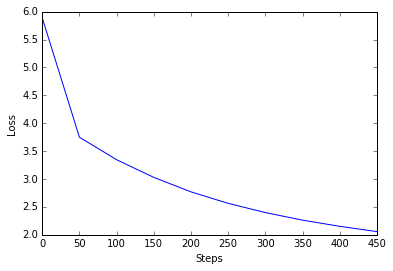

In [8]:

config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#,config=config
with tf.Session(graph=graph,config=config) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(NUM_STEPS):
        offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :, :, :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,keep_prob:DROPOUT_RATE}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            v_accuracy=accuracy(valid_prediction.eval(), valid_labels)
            print('Validation accuracy: %.1f%%' % v_accuracy)
            losses.append(l)
            steps.append(step)
            if v_accuracy>55:
                break

    plt.plot(steps,losses)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.show()
    
    WC1 = layer1_weights.eval(session)
    BC1 = layer1_biases.eval(session)
    WC2 = layer2_weights.eval(session)
    BC2 = layer2_biases.eval(session)
    WC3 = layer3_weights.eval(session)
    BC3 = layer3_biases.eval(session)
    WD1 = layer4_weights.eval(session)
    BD1 = layer4_biases.eval(session)
    W_OUT = layer5_weights.eval(session)
    B_OUT = layer5_biases.eval(session)


In [9]:

g = tf.Graph()
with g.as_default():
    x_input = tf.placeholder(tf.float32, shape=[None,IMAGE_HEIGHT, IMAGE_WIDTH,NUM_CHANNELS], name="input")

    WC1 = tf.constant(WC1, name="WC1")
    BC1 = tf.constant(BC1, name="BC1")
    CONV1 = conv2d(x_input, WC1, BC1)
    MAXPOOL1 = maxpool2d(CONV1, 2)

    WC2 = tf.constant(WC2, name="WC2")
    BC2 = tf.constant(BC2, name="BC2")
    CONV2 = conv2d(MAXPOOL1, WC2, BC2)
    MAXPOOL2 = maxpool2d(CONV2,2)

    WC3 = tf.constant(WC3, name="WC3")
    BC3 = tf.constant(BC3, name="BC3")
    CONV3 = conv2d(MAXPOOL2, WC3, BC3)
    MAXPOOL3 = maxpool2d(CONV3,1)

    WD1 = tf.constant(WD1, name="WD1")
    BD1 = tf.constant(BD1, name="BD1")

    FC1 = tf.reshape(MAXPOOL3, [-1, WD1.get_shape().as_list()[0]])
    FC1 = tf.add(tf.matmul(FC1, WD1), BD1)
    FC1 = tf.nn.relu(FC1)

    W_OUT = tf.constant(W_OUT, name="W_OUT")
    B_OUT = tf.constant(B_OUT, name="B_OUT")

    # skipped dropout for exported graph as there is no need for already calculated weights

    OUTPUT = tf.nn.softmax(tf.matmul(FC1, W_OUT) + B_OUT, name="output")

    sess = tf.Session()
    init = tf.initialize_all_variables()
    sess.run(init)

    graph_def = g.as_graph_def()
    tf.train.write_graph(graph_def, EXPORT_DIR, 'blood_cell_atemp.pb', as_text=False)

    # Test trained model
    y_train = tf.placeholder("float", [None, NUM_CLASSES])
    correct_prediction = tf.equal(tf.argmax(OUTPUT, 1), tf.argmax(y_train, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Model accuracy %g" % accuracy.eval({x_input: test_dataset, y_train: test_labels}, sess))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Model accuracy 0.25
